In [22]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('font', family='serif',size=20)
plt.rc('xtick',direction='in',labelsize=20,top=True)
plt.rc('ytick',direction='in',labelsize=20, right = True)
plt.rc('xtick.major',size = 12)
plt.rc('xtick.minor',size = 6)
plt.rc('ytick.major',size = 12)
plt.rc('ytick.minor',size = 6)
plt.rc('axes', labelsize = 20)

from astropy.io import fits as fits
from astropy.table import Table, hstack, join, vstack
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import glob, time 
import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask  
from desitarget.geomask import get_imaging_maskbits 
from desitarget.mtl import inflate_ledger

from desimodel.focalplane.geometry import xy2radec 

from desimodel.io import load_fiberpos 

from desitarget.geomask import circles 

nside = 32
orig_density_per_deg = 2500

#files
fba_file = '/global/cscratch1/sd/lbigwood/S4MOCK/20210406/fba-000174.fits'

In [66]:
f = fits.open(fba_file)
fba=Table(f['FASSIGN'].data)
ftar=Table(f['FTARGETS'].data)
favail=Table(f['FAVAIL'].data)

targets = Table.read('/global/cscratch1/sd/lbigwood/S4MOCK/20210406/000174-targ.fits')

mask,idx = np.unique(fba['TARGETID'].data,return_index=True)
fba = fba[idx]x

fba.dtype.names

('FIBER',
 'TARGETID',
 'LOCATION',
 'FIBERSTATUS',
 'LAMBDA_REF',
 'PETAL_LOC',
 'DEVICE_LOC',
 'DEVICE_TYPE',
 'TARGET_RA',
 'TARGET_DEC',
 'FA_TARGET',
 'FA_TYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y')

In [65]:
join(targets, fba, join_type='left', '')

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  364 / length of dimension 1                          
NAXIS2  =                    0 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   60 / number of table fields                         
TTYPE1  = 'RELEASE '                                                            
TFORM1  = 'I       '                                                            
TTYPE2  = 'BRICKID '                                                            
TFORM2  = 'J       '                                                            
TTYPE3  = 'BRICKNAME'       

In [76]:
targets = fits.open('/global/cscratch1/sd/lbigwood/S4MOCK/20210406/000201-targ.fits')
targets.info()

Filename: /global/cscratch1/sd/lbigwood/S4MOCK/20210406/000201-targ.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    128   0R x 60C   [I, J, 8A, J, 4A, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, K, 2A, E, E, E, 1A, K, D, D, E, E, E, E, K, K, K, D, J, K, K, K, K, K, D, K, J, 30A, 25A, 14A, K, D, D, E]   


In [62]:
favail['TARGETID'].data

array([616094038679880162, 616094038679880197, 616094038679880268, ...,
       616094019985867061, 616094019985867026, 616094019985867095])

In [26]:
f[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   66 / width of table in bytes                        
NAXIS2  =                 5020 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   14 / number of fields in each row                   
TTYPE1  = 'FIBER   '           / label for field   1                            
TFORM1  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE2  = 'TARGETID'           / label for field   2                            
TFORM2  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE3  = 'LOCATION'        

In [3]:
fba.dtype.names

('FIBER',
 'TARGETID',
 'LOCATION',
 'FIBERSTATUS',
 'LAMBDA_REF',
 'PETAL_LOC',
 'DEVICE_LOC',
 'DEVICE_TYPE',
 'TARGET_RA',
 'TARGET_DEC',
 'FA_TARGET',
 'FA_TYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y')

In [4]:
ftar.dtype.names

('TARGETID',
 'TARGET_RA',
 'TARGET_DEC',
 'FA_TARGET',
 'FA_TYPE',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS')

In [5]:
np.mean(np.isin(fba['TARGETID'].data, ftar['TARGETID'].data))

0.8864541832669323

In [6]:
np.mean(np.isin(ftar['TARGETID'].data, fba['TARGETID'].data))

1.0

In [7]:
#ftarfba = join(ftar, fba, join_type='left', keys='TARGETID')
#ftarfba

In [8]:
theta = np.pi/2. - np.radians(ftar['TARGET_DEC'].data)
phi   = np.radians(ftar['TARGET_RA'].data)

In [9]:
np.sort(theta) / np.pi

array([0.19882075, 0.1988823 , 0.19889728, ..., 0.21660485, 0.21664658,
       0.21672925])

In [10]:
hp.ang2pix?

Signature: hp.ang2pix(nside, theta, phi, nest=False, lonlat=False)
Docstring:
ang2pix : nside,theta[rad],phi[rad],nest=False,lonlat=False -> ipix (default:RING)

Parameters
----------
nside : int, scalar or array-like
  The healpix nside parameter, must be a power of 2, less than 2**30
theta, phi : float, scalars or array-like
  Angular coordinates of a point on the sphere
nest : bool, optional
  if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
lonlat : bool
  If True, input angles are assumed to be longitude and latitude in degree,
  otherwise, they are co-latitude and longitude in radians.

Returns
-------
pix : int or array of int
  The healpix pixel numbers. Scalar if all input are scalar, array otherwise.
  Usual numpy broadcasting rules apply.

See Also
--------
pix2ang, pix2vec, vec2pix

Examples
--------
Note that some of the test inputs below that are on pixel boundaries
such as theta=pi/2, phi=pi/2, have a tiny value of 1e-15 added to them
to make them re

In [11]:
idxs  = hp.ang2pix(nside, theta, phi, nest=True)
idxs  = np.unique(idxs)

In [55]:
# root   = '/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv3/bright/'
root   = '/global/cscratch1/sd/mjwilson/S4MOCK/orig_mtls/bright/'

ledger = [Table.read('{}/sv3mtl-bright-hp-{:d}.ecsv'.format(root, x)) for x in idxs]
ledger = vstack(ledger)
ledger

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
deg,deg,yr,mas,mas / yr,mas / yr,,,,,,,,,,,,,,,,s,,
float64,float64,float32,float32,float32,float32,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,float64,int64,int32,str19,str19,str13,int64
215.07443165287384,48.36937078952621,0.0,0.0,0.0,0.0,39633220689463591,1152921504606846976,514,0,0.46494532751034534,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.11643351901827,48.33774517489074,0.0,0.0,0.0,0.0,39633220689464031,1152921504606855433,514,0,0.20478439854092467,517,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.12800357732308,48.352739770582794,2015.5,0.15349352,-3.4217763,1.8129401,39633220689464126,2305843009213693952,0,6144,0.7051820192643213,516,101500,9,0,9,0,-1.0,-1,-1,MWS_MAIN_RED|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,101500
215.12947375040815,48.349827968794024,2015.5,0.2901149,-4.458679,-13.605956,39633220689464144,2305843009213693952,0,768,0.05684455213364459,516,101500,9,0,9,0,-1.0,-1,-1,MWS_MAIN_BLUE|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,101500
215.13467749276734,48.37326240749387,0.0,0.0,0.0,0.0,39633220689464179,5764607523034234880,514,0,0.0688163183694851,575,102100,9,79164837199872,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.13685215873315,48.35238977571062,2015.5,0.46409887,-13.290274,-1.5982466,39633220689464210,2305843009213693952,0,768,0.8597790328624232,516,101500,9,0,9,0,-1.0,-1,-1,MWS_MAIN_BLUE|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,101500
215.14286946751162,48.348975827660446,2015.5,0.17900495,-5.2331843,-6.1188006,39633220689464268,2305843017803628544,0,768,0.8353423495464815,519,101500,9,0,9,0,-1.0,-1,-1,MWS_MAIN_BLUE|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,101500
215.15728311069572,48.33333927256715,2015.5,0.37856752,0.041762915,0.5235049,39633220689464394,2305843009213694980,0,768,0.9363876856861748,517,101500,9,0,9,0,-1.0,-1,-1,MWS_MAIN_BLUE|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,101500


In [56]:
bgsbright_ledger = ledger[(ledger['SV3_BGS_TARGET'].data & bgs_mask['BGS_BRIGHT']) != 0 ]
bgsbright_ledger

RA,DEC,REF_EPOCH,PARALLAX,PMRA,PMDEC,TARGETID,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,SV3_SCND_TARGET,NUMOBS_MORE,NUMOBS,Z,ZWARN,ZTILEID,TARGET_STATE,TIMESTAMP,VERSION,PRIORITY
deg,deg,yr,mas,mas / yr,mas / yr,,,,,,,,,,,,,,,,s,,
float64,float64,float32,float32,float32,float32,int64,int64,int64,int64,float64,int32,int64,int64,int64,int64,int64,float64,int64,int32,str19,str19,str13,int64
215.07443165287384,48.36937078952621,0.0,0.0,0.0,0.0,39633220689463591,1152921504606846976,514,0,0.46494532751034534,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.11643351901827,48.33774517489074,0.0,0.0,0.0,0.0,39633220689464031,1152921504606855433,514,0,0.20478439854092467,517,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.13467749276734,48.37326240749387,0.0,0.0,0.0,0.0,39633220689464179,5764607523034234880,514,0,0.0688163183694851,575,102100,9,79164837199872,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.1820101921716,48.28794265867681,0.0,0.0,0.0,0.0,39633220693655619,1152921504606846976,514,0,0.7424310450131372,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.21484046181732,48.27924564371001,0.0,0.0,0.0,0.0,39633220693655920,1152921504606846976,514,0,0.831812734762623,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.21891166435236,48.27827692913309,0.0,0.0,0.0,0.0,39633220693655969,1152921504606846976,514,0,0.8600268107310813,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.2211741800572,48.28725632582145,2015.5,0.0,0.0,0.0,39633220693655995,1152921504606846976,514,0,0.502161075379653,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100
215.22749037761773,48.24709676047756,0.0,0.0,0.0,0.0,39633220693656054,1152921504606846976,514,0,0.8421778534359137,516,102100,9,0,9,0,-1.0,-1,-1,BGS_BRIGHT|UNOBS,2021-06-16T03:18:06,1.1.1.dev5118,102100


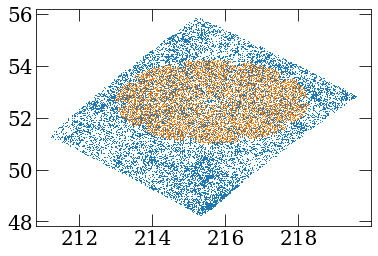

In [57]:
plt.plot(bgsbright_ledger['RA'].data, bgsbright_ledger['DEC'].data, marker=',', lw=0.0)
plt.plot(fba['TARGET_RA'].data, fba['TARGET_DEC'].data, marker=',', lw=0.0)

In [58]:
# go back to alt mtl ledgers. 
np.mean(np.isin(fba['TARGETID'].data, bgsbright_ledger['TARGETID'].data))

0.0

In [28]:
bgsbright_ledger.dtype.names

('RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'TARGETID',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

In [ ]:
# sv3 targeting catalogs. 

In [30]:
ftarfba.dtype.names

('TARGETID',
 'TARGET_RA_1',
 'TARGET_DEC_1',
 'FA_TARGET_1',
 'FA_TYPE_1',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'FIBER',
 'LOCATION',
 'FIBERSTATUS',
 'LAMBDA_REF',
 'PETAL_LOC',
 'DEVICE_LOC',
 'DEVICE_TYPE',
 'TARGET_RA_2',
 'TARGET_DEC_2',
 'FA_TARGET_2',
 'FA_TYPE_2',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y')

In [31]:
ftar.dtype.names

('TARGETID',
 'TARGET_RA',
 'TARGET_DEC',
 'FA_TARGET',
 'FA_TYPE',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS')

In [29]:
# to_grab will be a list of file paths for files in the directory provided.  	 
to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv3/bright/sv3mtl-bright-hp-*.ecsv') 
#to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/main/bright/mtl-bright-hp-*.ecsv') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

start = time.time() 

npix_todo = 14000

mmask = 'SV3_BGS_TARGET'
ttype = 'BGS_BRIGHT'

for i, x in enumerate(to_grab):
    x = pd.read_csv(x, comment='#', delimiter='\s+', usecols=['RA', 'DEC', 'TARGETID', 'SV3_BGS_TARGET', 'SV3_MWS_TARGET'])

    is_bright = (x[mmask] & bgs_mask[ttype]) != 0

    idx = np.arange(len(x))[is_bright]
    
    x = x.iloc[idx] 
    
    hp_stack.append(x)

    if (i % 100) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    if i > npix_todo:
        break
        
# Create a big table from the list of tables.  
# data_stack = vstack(hp_stack) 

data_stack = pd.concat(hp_stack, ignore_index=True)

mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack.iloc[idx]

data_stack = Table.from_pandas(data_stack)

runtime = (time.time() - start)

print('\n\nTotal runtime of {:.6f} seconds after {:d} pixels'.format(runtime, npix_todo))

data_stack

Runtime of 0.084149 seconds after 0 pixels
Runtime of 7.250751 seconds after 100 pixels


Total runtime of 10.612442 seconds after 14000 pixels


RA,DEC,TARGETID,SV3_BGS_TARGET,SV3_MWS_TARGET
float64,float64,int64,int64,int64
210.85626940232424,-4.634859698793711,39627673575621022,131074,0
210.8564987523507,-4.702473821014708,39627673575621026,131074,0
210.85818873384545,-4.663899083984044,39627673575621057,131074,0
210.87061299442456,-4.718240594587042,39627673575621348,131074,0
210.88032110056568,-4.6953073075369165,39627673575621558,131074,0
210.88243419349791,-4.6970596959406175,39627673575621632,131074,0
210.8864973162201,-4.647658181600011,39627673575621751,131074,0
210.90088216473117,-4.627224418862031,39627673575622101,131074,0
210.91571050310785,-4.725330482495628,39627673575622441,131074,0


In [4]:
assigned_data_stack = data_stack[np.isin(data_stack['TARGETID'],fba['TARGETID'])]

print(len(assigned_data_stack['RA'].data))



0


In [33]:
tilera=f[1].header['TILERA']
tiledec=f[1].header['TILEDEC']

tilera, tiledec

(215.615, 52.598)

In [44]:
isbad = fba['FIBERSTATUS'].data > 0

bad_locs = fba['LOCATION'].data[isbad]
len(bad_locs)

892

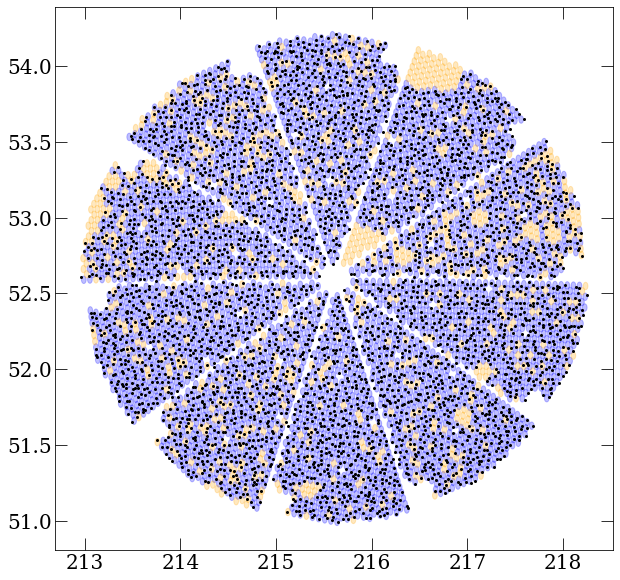

In [54]:
#use right centre from fba header 
plt.figure(figsize = (10,10))

patrol_radii=1.48/60. # degrees 

fp = load_fiberpos() 

ra, dec = xy2radec(tilera, tiledec, fp["X"], fp["Y"]) 

is_badloc = np.isin(fp['LOCATION'].data, bad_locs)

circles(ra[~is_badloc], dec[~is_badloc], s=patrol_radii, c='b', alpha=0.25) 
circles(ra[is_badloc], dec[is_badloc], s=patrol_radii, c='orange',alpha=0.25)

plt.plot(ftar['TARGET_RA'].data, ftar['TARGET_DEC'].data, c='k', marker='.', markersize=4, lw=0.0)